# Text Analysis

In [30]:
import re
import nltk
import torch
from itertools import chain, repeat
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer

In [2]:
# configure matplotlib output
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('config/clean.mplstyle') # this loads my personal plotting settings
col = mpl.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

In [3]:
# if you have an HD display
%config InlineBackend.figure_format = 'retina'

In [4]:
# some warnings can get annoying
import warnings
warnings.filterwarnings('ignore')

In [5]:
from tools.text import process_text, total_params, batch_indices

In [6]:
# here you can set which device to use
device = 'cuda' # 'cpu'

## Text Analysis

We're going to bring in some tools from the pure language side such as `nltk`, the natural language toolkit. This let's you easily bring in some public domain works, particularly those from Project Gutenberg..ipynb_checkpoints/lecture_4-checkpoint.ipynb:    "def generate_sequences(vec, l):\n",


In [7]:
# download gutenberg corpus
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to
[nltk_data]     /media/genesis/data/nltk...
[nltk_data]   Package gutenberg is already up-to-date!


True

Let's see what books we get from this particular archive. Some good stuff here. Sense and Sensibility!

In [8]:
# list available books
books = nltk.corpus.gutenberg.fileids()
names = [s.split('.')[0] for s in books]
print(', '.join(names))

austen-emma, austen-persuasion, austen-sense, bible-kjv, blake-poems, bryant-stories, burgess-busterbrown, carroll-alice, chesterton-ball, chesterton-brown, chesterton-thursday, edgeworth-parents, melville-moby_dick, milton-paradise, shakespeare-caesar, shakespeare-hamlet, shakespeare-macbeth, whitman-leaves


It's kind of wonky, but you can read each of these through a file-like object. Let's look at an early paragraph from Moby Dick.

In [9]:
# get text of all books (corpus)
text = [nltk.corpus.gutenberg.open(f).read() for f in books]
print(text[12][117:443])

The pale Usher--threadbare in coat, heart, body, and brain; I see him
now.  He was ever dusting his old lexicons and grammars, with a queer
handkerchief, mockingly embellished with all the gay flags of all the
known nations of the world.  He loved to dust his old grammars; it
somehow mildly reminded him of his mortality.


Now let's look at how long each book is (in terms of characters) and display it as a `DataFrame`.

In [10]:
# get basic info about each text
ndocs = len(text)
length = np.array([len(x) for x in text])
info = pd.DataFrame({'name': names, 'length': length})
info

,name,length
0,austen-emma,887071
1,austen-persuasion,466292
2,austen-sense,673022
3,bible-kjv,4332554
4,blake-poems,38153
5,bryant-stories,249439
6,burgess-busterbrown,84663
7,carroll-alice,144395
8,chesterton-ball,457450
9,chesterton-brown,406629


Before using this for anything serious, we're going to want to eliminate any unusual punctuation and merge any whitespace together. Then we're left with something kind of standardized but still readable.

In [11]:
text1 = [process_text(s) for s in text]
print(text1[2][20000:21000])

decision was wanting before , and he finally resolved , that it would be absolutely unnecessary , if not highly indecorous , to do more for the widow and children of his father , than such kind of neighbourly acts as his own wife pointed out .
chapter 3
mrs . dashwood remained at norland several months , not from any disinclination to move when the sight of every well known spot ceased to raise the violent emotion which it produced for a while , for when her spirits began to revive , and her mind became capable of some other exertion than that of heightening its affliction by melancholy remembrances , she was impatient to be gone , and indefatigable in her inquiries for a suitable dwelling in the neighbourhood of norland , for to remove far from that beloved spot was impossible . but she could hear of no situation that at once answered her notions of comfort and ease , and suited the prudence of her eldest daughter , whose steadier judgment rejected several houses as too large for thei

From here we use the `sklearn` tools for text vectorization. The first is a raw count of words, meaning we'll get back a sparse matrix with one row for each book and one column for each word in our vocabulary.

In [12]:
cv = CountVectorizer(stop_words='english')
counts = cv.fit_transform(text1)
nbook, nwrd = counts.shape
counts

<18x41757 sparse matrix of type '<class 'numpy.int64'>'
	with 117238 stored elements in Compressed Sparse Row format>

Note that here we call `fit_transform`, meaning the `fit` part determines our vocabulary from the corpus and the `transform` part actually does the numerical conversion. You may sometimes want to do these separately or to use a pre-existing vocabular instead. There are options for this. The other slightly more advanced alternative is to down-weight each word by its usage frequency in the overall corpus, thus reducing focus on common words such as "the" and "is". This returns a sparse `float` matrix instead.

In [13]:
tfidf = TfidfVectorizer(stop_words='english')
vecs = tfidf.fit_transform(text1)
vecs

<18x41757 sparse matrix of type '<class 'numpy.float64'>'
	with 117238 stored elements in Compressed Sparse Row format>

### Text Similarity

We should always try to deal with $\ell^2$ normalized vectors. In the case of general vectors, the cosine similarity is
\\[
cos(\theta(x,y)) = \frac{x \cdot y}{||x|| \cdot ||y||}
\\]
But when our vectors are $\ell^2$ normalized, we have $||x|| = ||y|| = 1$, so the cosine similarity is simply the dot product $x \cdot y$. Also note that in this case, the Euclidean distance between two vectors is
\\[
d(x,y) = (x-y) \cdot (x-y) = ||x|| + ||y|| - 2 x \cdot y = 2 ( 1 - x \cdot y )
\\]
which is a monotone and linear function of the cosine similarity, meaning they are essentially equivalent. Let's check that all of our document vectors are properly normalized.

In [14]:
vecs.power(2).sum(axis=1).getA1()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

One nice thing about vector representations is that our corpus is simply a matrix, meaning we can do this like find the similarity between all pairs of documents with a simply matrix product. Here we can see some clustering within Austen and Shakespeare.

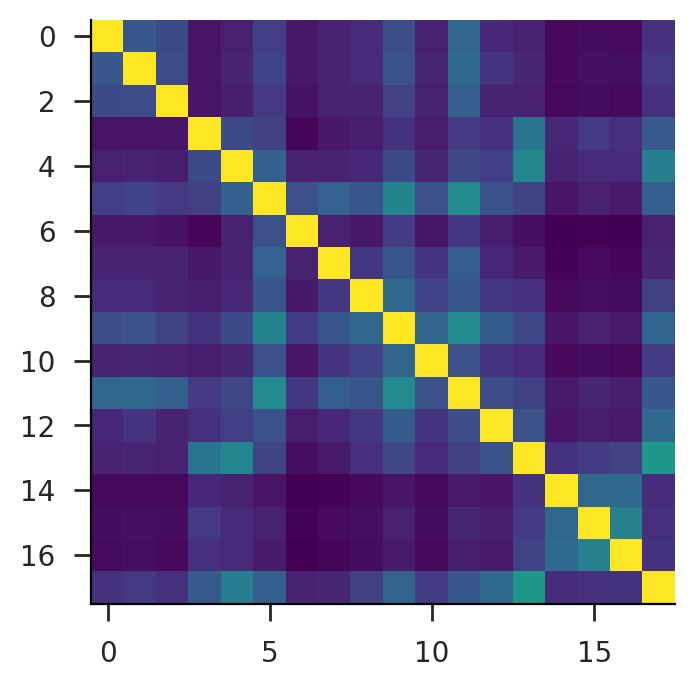

In [15]:
sim = (vecs @ vecs.T).todense().getA() # not always feasible for big corpora
plt.imshow(sim); # sqrt enhances differences

We also may want to compute word-level statistics. Here we print our a list of the most common words in the corpus. This might seem a bit odd at first, but if you note that the King James Version (KVJ) bible is far longer than any other book, it makes a bit more sense. We could downweight this a bit by replacing the `sum` below with a `mean`.

In [16]:
# get the most commonly used words
all_count = counts.sum(axis=0).getA1()
all_rank = np.argsort(-all_count)
all_words = cv.get_feature_names_out()
print('\n'.join([
    f'{all_words[i]} — {all_count[i]}' for i in all_rank[:20]
]))

shall — 11682
said — 9429
unto — 9010
lord — 8590
thou — 6759
man — 5615
thy — 5609
god — 5287
thee — 4807
ye — 4674
come — 3642
like — 3468
came — 3337
day — 3326
king — 3149
did — 3121
little — 3065
know — 3057
house — 2900
good — 2899


Very common words like `the` and `and` account for a very large fraction of total words. We can visualize this by looking at the cumulative share of words accounted by each word in order of overall frequency. This is actually just the Lorenz curve that is used to calculate a Gini coefficient. So we can also calculate a Gini coefficient over words by integrating this. Here we find a value of $86\%$.

0.8576843343208485


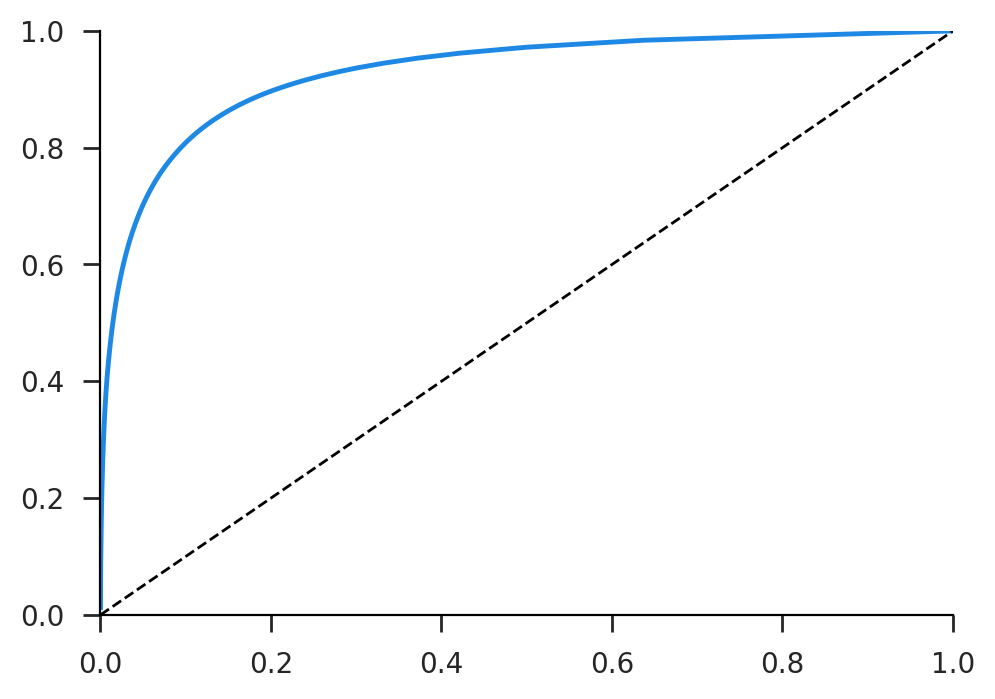

In [17]:
word_cdf = np.cumsum(all_count[all_rank])/np.sum(all_count)
word_gini = 2*(np.sum(word_cdf)/nwrd-0.5)
word_index = np.linspace(0, 1, nwrd)
pd.Series(word_cdf, index=word_index).plot(xlim=(0, 1), ylim=(0, 1))
plt.plot(word_index, word_index, linestyle='--', linewidth=1, c='k')
print(word_gini)

Now let's make a general function that calculates the Gini coefficient for a single book and apply this to each book. Here we can see that our boy Melville is a real outlier again! Moby Dick has by far the lowest Gini value, meanining it has a more equal distribution over word usage.

In [18]:
def word_gini(c):
    n = len(c)
    s = -np.sort(-c)
    cdf = np.cumsum(s)/np.sum(c)
    gini = 2*(np.sum(cdf)/n-0.5)
    return gini
ginis = [word_gini(counts[i,:].todense().getA1()) for i in range(nbook)]
info.assign(gini=ginis).sort_values(by='gini')

,name,length,gini
12,melville-moby_dick,1242990,0.875626
17,whitman-leaves,711215,0.900018
13,milton-paradise,468220,0.926976
8,chesterton-ball,457450,0.932614
9,chesterton-brown,406629,0.934194
10,chesterton-thursday,320525,0.946722
11,edgeworth-parents,935158,0.948896
0,austen-emma,887071,0.957791
2,austen-sense,673022,0.957912
15,shakespeare-hamlet,162881,0.958049


### Text Visualization

One common method of visualizing word frequency vectors is to project them down onto a much lower dimensional space, in this case two dimensions. The most widely used such method is called `TSNE` and is included in `sklearn`.

In [19]:
tsne = TSNE(init='random', perplexity=10)
embed = tsne.fit_transform(vecs)

Now we can plot these in a plane, and it's evident that you see clustering of a similar nature to that seen in the similarity matrix.

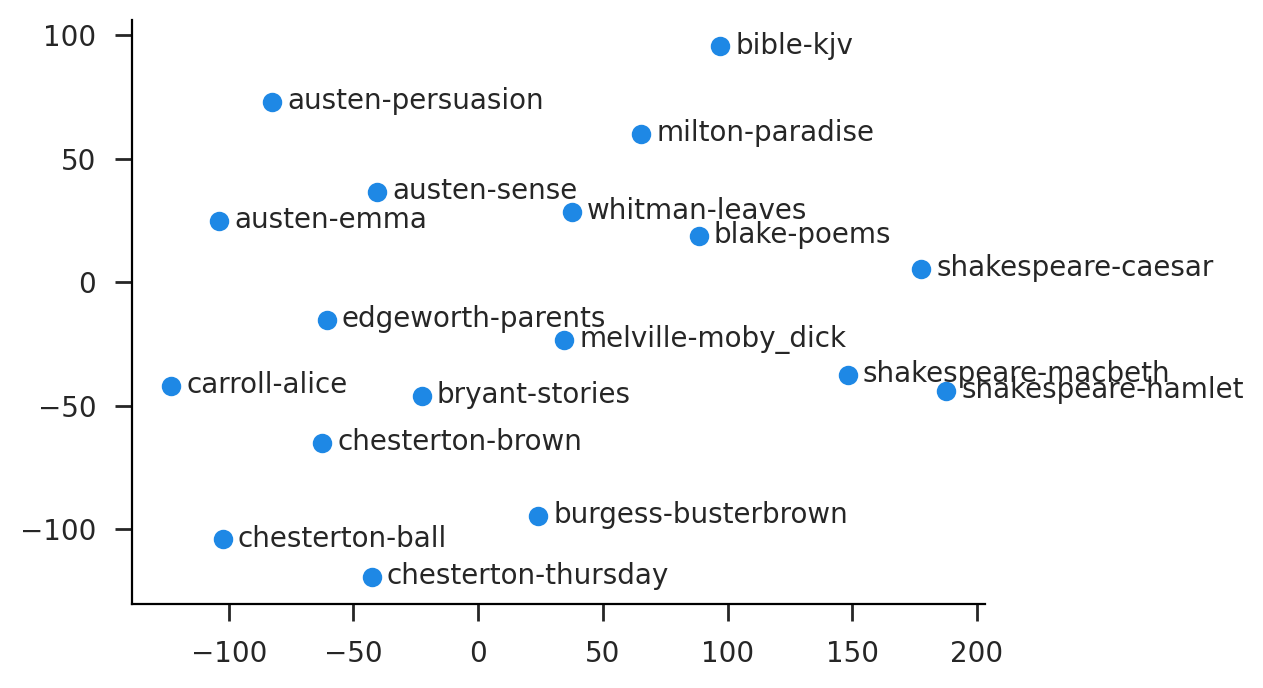

In [20]:
fig, ax = plt.subplots()
ax.scatter(*embed.T)
for i in range(nbook):
    ax.annotate(
        names[i], embed[i], xytext=(15, -7),
        textcoords='offset pixels', fontsize=10
    )

## Embeddings

One issue with using work frequency vectors, however we weight them, is that we won't really be handling synonyms well. Embeddings are just mappings from words or tokens into dense numerical representations, rather than the sparse frequency vectors we've seen so far. These embeddings will (hopefully) map similar words and concepts into similar vectors, meaning we can understand document similarity by looking at the their vector similarity.

Usually you'll be using pre-trained embeddings that have proven accuracy at various tasks, but first let's look at the basic technical construct in `torch`. That would be `nn.Embedding`. This requires two arguments: the size of your vocabulary and the size of the resulting vector. Once created, the embedding is a function (actually it's a class that implements `__call__`) that maps from integer indices into vectors. These indices are just the index of a given word in the vocabulary, so to actually get the embedding for a given word, you have to map from word to index (tokenize) then pass that index to the embedding.

In [21]:
emb = nn.Embedding(1000, 5)
idx = torch.arange(3)
emb(idx)

tensor([[-0.1713, -0.7461,  0.5263,  2.7701,  0.5244],
        [ 0.2371,  1.0747,  0.2888,  0.4597, -1.3020],
        [-1.2402,  0.6332,  1.2205,  0.2588, -0.4132]],
       grad_fn=<EmbeddingBackward0>)

The above code creates the embedding then looks at the vectors for the first three indices. Of course, we haven't trained or initialized this embedding in any way, so the numbers are just random. We don't have an associated vocabulary, so this is all pretty abstract. Additionally, we generally don't want to find the embedding for just one word, we want it for an entire string or set of strings.

For this we need to move on to sentence level embeddings. These are typically based on the transformer models that power most large language models today, though they are much smaller in terms of parameter count that LLMs. We'll go over the inner workings of transforms in the next lecture, for now we just need their output. To access these, we'll go through the `sentence_transformers` library from HuggingFace. There are tons of different models to choose from, but I'll use one that's particularly high performance for its size.

In [22]:
mod = SentenceTransformer('TaylorAI/bge-micro-v2').to(device)
print(total_params(mod))
mod

2023-11-29 02:22:45.497691: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 02:22:45.517237: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 02:22:46.045747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


17389824


SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

If you just want to go straight from text to embeddings, use `mod.encode`. I'm going to do the tokenization (`mod.tokenizer`) and embedding (`mod.forward`) steps separately, because we need to break these into chunks for it to work. First we tokenize into a matrix of word ids.

In [23]:
toks = mod.tokenizer(
    text, max_length=256, padding='max_length', truncation=True,
    return_overflowing_tokens=True, return_tensors='pt'
).to(device)
nchunks, nlen = toks.input_ids.shape
ndim = mod.get_sentence_embedding_dimension()

Then we embed these ids into vectors. Note the `torch.no_grad`! This is important, without it your memory usage will explode because `torch` will be tracking gradients.

In [24]:
embeds = torch.zeros(nchunks, ndim, dtype=torch.float, device=device)
for i1, i2 in tqdm(batch_indices(nchunks, 16)):
    feats = {
        'input_ids': toks.input_ids[i1:i2,:],
        'attention_mask': toks.attention_mask[i1:i2,:]
    }
    with torch.no_grad():
        ret = mod.forward(feats)
    embeds[i1:i2,:] = F.normalize(ret['sentence_embedding'])
    embeds.shape

100%|████████████████████████████████████████| 706/706 [00:04<00:00, 157.80it/s]


If we wanted to something like semantic search over this corpus, it would be fine to keep the embeddings chunked, but we may also want to look at document level statistics, so lets reaggregate them up to the document level.

In [25]:
doc_embeds = F.normalize(torch.stack([
    embeds[toks.overflow_to_sample_mapping==i].mean(0) for i in range(ndocs)
], 0))
doc_embeds.shape

torch.Size([18, 384])

Now we can again look at the similarity matrix. Here we see that the clustering is a bit more distinct, and Chesterton's unique style becomes more evident, as does the KJV.

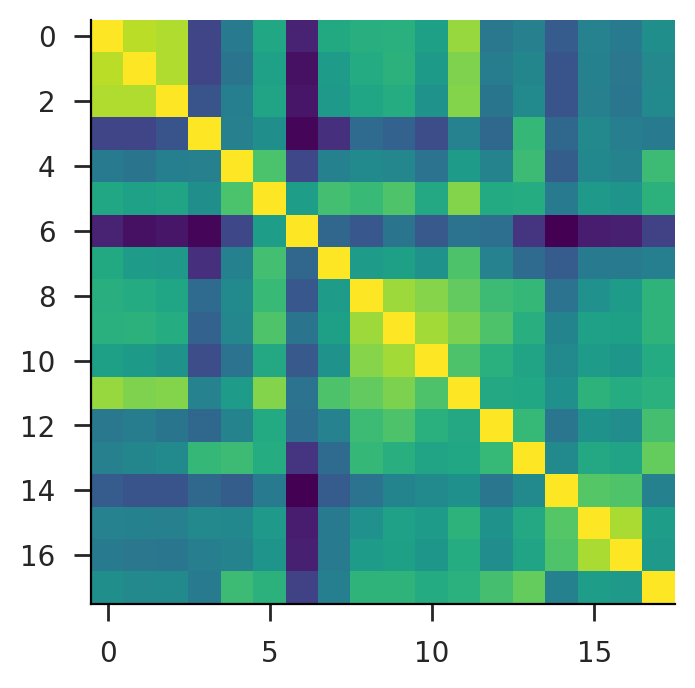

In [26]:
# get the full similarity matrix
sime = (doc_embeds @ doc_embeds.T).cpu() # not always feasible for big corpora
plt.imshow(sime); # sqrt enhances differences

Finally, let's compute `TSNE` on these vectors as well. These are much smaller (`D=384`) than our word vectors (`D=41757`), but it's still too much to visualize for mere humans.

In [27]:
tsne1 = TSNE(init='random', perplexity=10)
doc_tsne = tsne1.fit_transform(doc_embeds.cpu())

Here we end up seeing similar clustering patterns, though the groups are a bit more distinct.

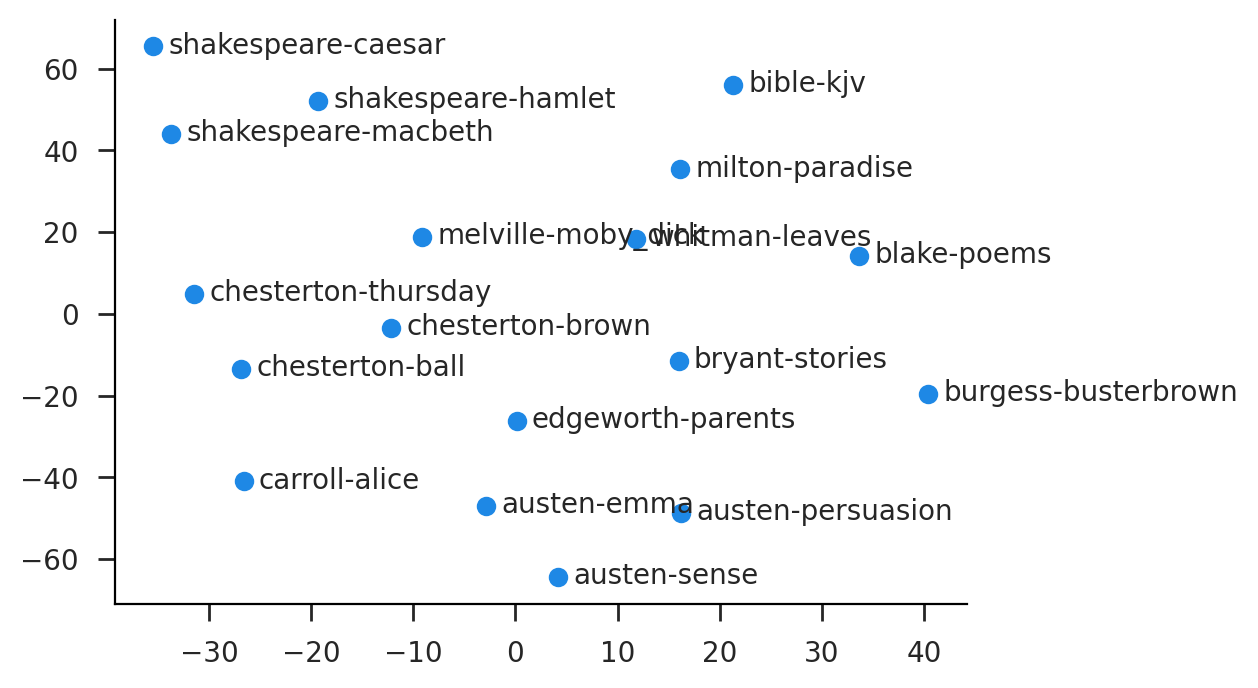

In [28]:
fig, ax = plt.subplots()
ax.scatter(*doc_tsne.T)
for i in range(nbook):
    ax.annotate(
        names[i], doc_tsne[i], xytext=(15, -7),
        textcoords='offset pixels', fontsize=10
    )

In general, Huggingface is your friend! They are the go to place for machine learning models of almost any sort. For instance, you can read about the `TaylorAI/bge-micro-v2` model at https://huggingface.co/TaylorAI/bge-micro-v2 (kind of like GitHub in the URL pattern). There's a leaderboard for embedding models at https://huggingface.co/spaces/mteb/leaderboard. And I have a blog post going over some of the speed and accuracy considerations at http://doughanley.com/blogs/?post=embed.

## Classification

Now let's unpack these books a little bit and look at sentence level embeddings again. To do this, instead of breaking up the documents arbitrarily as above, we'll do it at the sentence level and simply truncate longer sentences. Chunking documents is actually pretty difficult sometimes due to inconsistencies in formatting. We're just going to split by periods and throw out short sentneces.

In [136]:
def strip_whitespace(s):
    return re.sub(r'\s+', ' ', s).strip()
def split_document(doc):
    doc = re.sub(r'(Mrs|Mr)\.', r'\1', doc)
    return doc.split('.')
def sentence_splitter(doc, minlen=100):
    return [strip_whitespace(s)+'.' for s in split_document(doc) if len(s) >= minlen]

In [155]:
books = [sentence_splitter(d) for d in text]
sentences = list(chain.from_iterable(books))
book_ids = np.array(list(chain.from_iterable(repeat(i, len(d)) for i, d in enumerate(books))))
print(len(sentences))

45540


In [148]:
sembeds = mod.encode(sentences, show_progress_bar=True)

Batches:   0%|          | 0/1424 [00:00<?, ?it/s]

In [149]:
stsne = TSNE(init='random', perplexity=10)
stsne_vals = stsne.fit_transform(sembeds)

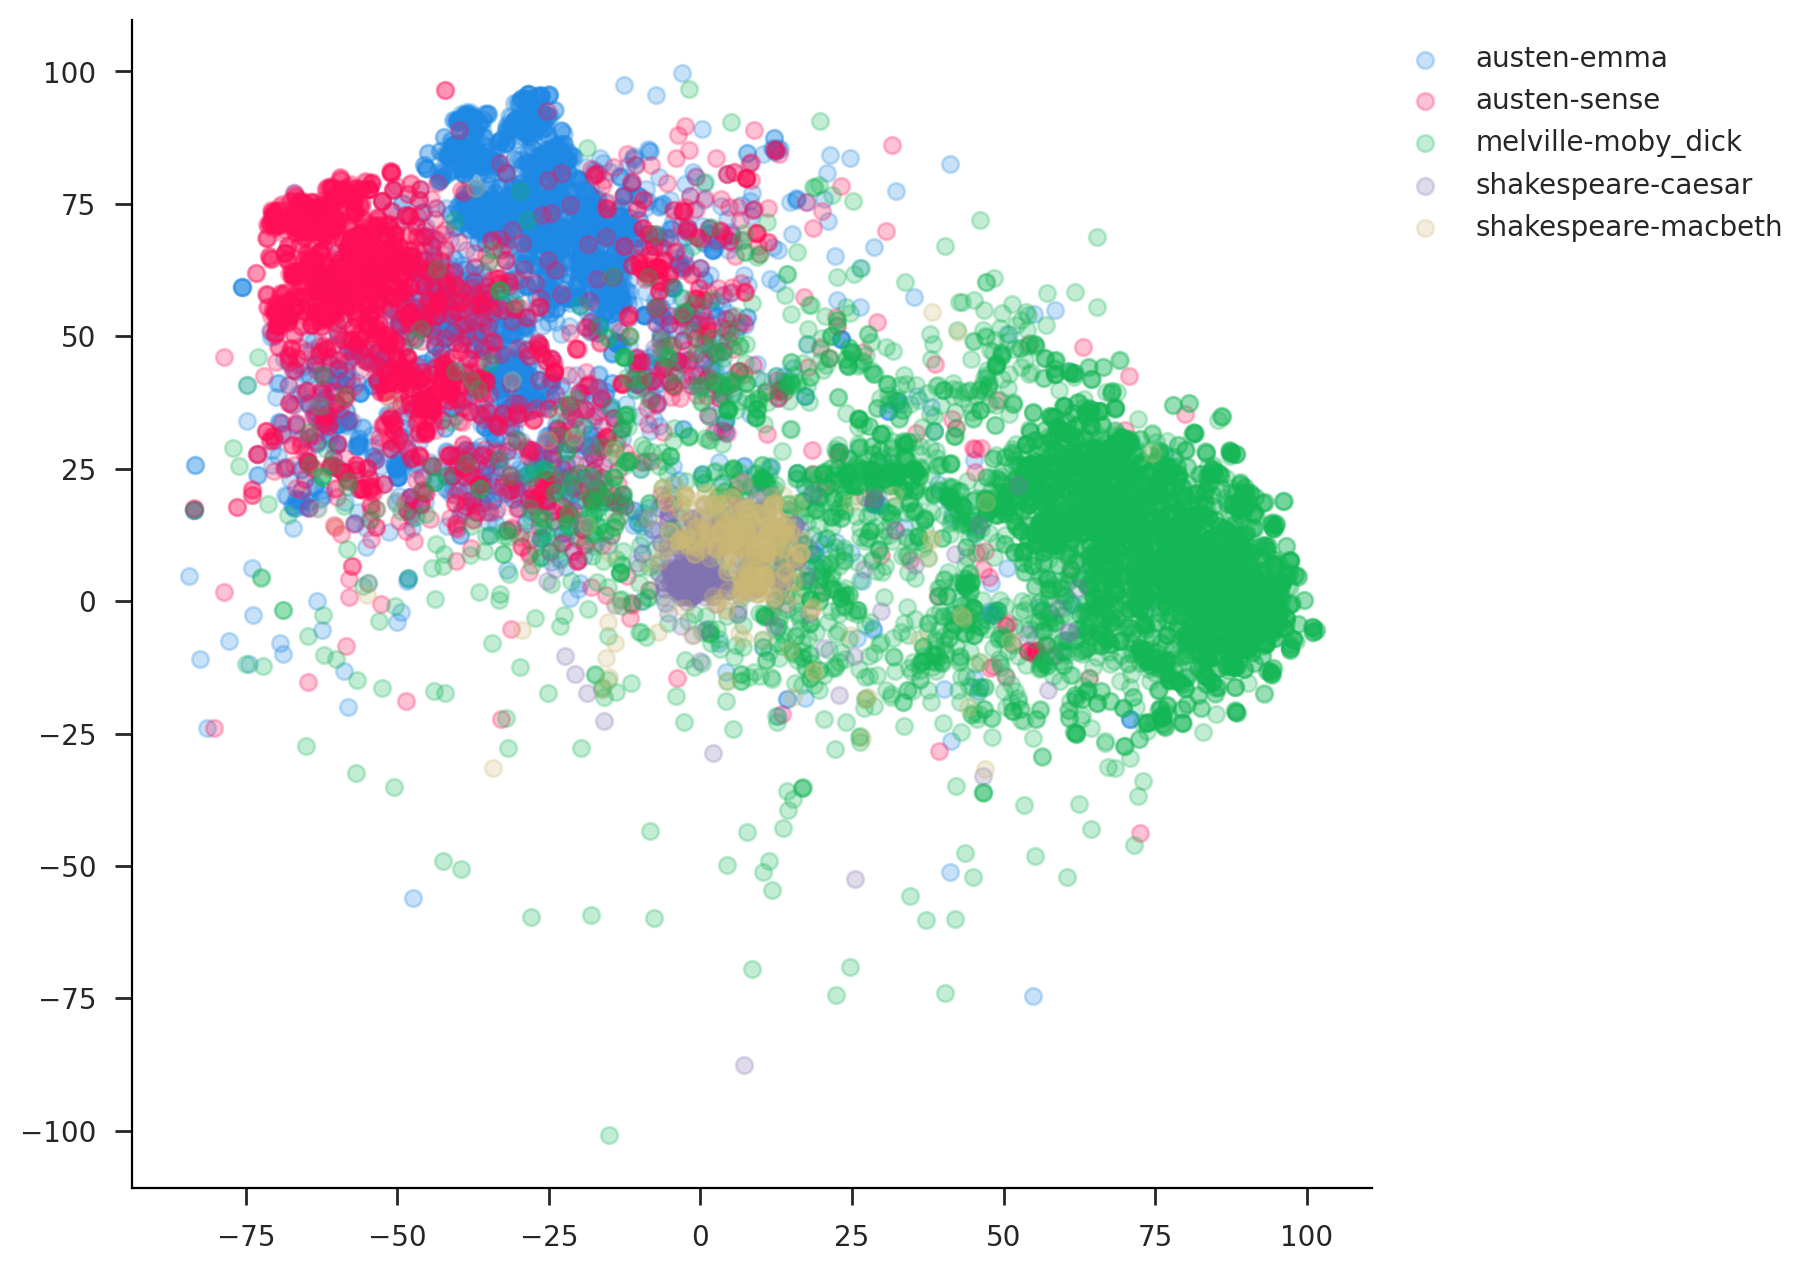

In [200]:
fig, ax = plt.subplots(figsize=(8, 8))
for i in [0, 2, 12, 14, 16]:
    plt.scatter(*stsne_vals[book_ids==i,:].T, alpha=0.25, label=names[i])
plt.legend(bbox_to_anchor=(1, 1));